# News Recommendation System Project Comp9727

**Nama**: PanHang\
**zID**: z5598515\
**Email**: z5598515@ad.unsw.edu.au

Three news recommendation systems were constructed and evaluated, using the dataset MIND. The adopted methods include content-based filtering (using TF-IDF/ Bert) and collaborative filtering (based on the embedding model of pytorch). The evaluation method is Precision@K, based on the category matching degree of users' historical preferences.

# 1. Load Data

In [4]:
import os
import ast
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)

In [5]:
!pip install sentence-transformers # to load bert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [8]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [9]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [10]:
behaviors = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv', sep='\t', 
                        names=["Impression_ID", "User_ID", "Time", "History", "Impressions"])

news = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/news.tsv', sep='\t',
                   names=["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"])


# 2. Data Preprocessing

In [11]:
news.head()

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [12]:
behaviors.head()

,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


### 2.1. Data Cleaning

In [13]:
def parse_impressions(imp_str):
    if pd.isna(imp_str):
        return []
    items = imp_str.strip().split(' ')
    return [(i.split('-')[0], int(i.split('-')[1])) for i in items]

behaviors['Impressions_parsed'] = behaviors['Impressions'].apply(parse_impressions)


In [14]:
def parse_history(history_str):
    if pd.isna(history_str):
        return []
    return history_str.strip().split(' ')

behaviors['History_parsed'] = behaviors['History'].apply(parse_history)


In [15]:
behaviors

,Impression_ID,User_ID,Time,History,Impressions,Impressions_parsed,History_parsed
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,"[(N55689, 1), (N35729, 0)]","[N55189, N42782, N34694, N45794, N18445, N6330..."
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,"[(N20678, 0), (N39317, 0), (N58114, 0), (N2049...","[N31739, N6072, N63045, N23979, N35656, N43353..."
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,"[(N50014, 0), (N23877, 0), (N35389, 0), (N4971...","[N10732, N25792, N7563, N21087, N41087, N5445,..."
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,"[(N35729, 0), (N33632, 0), (N49685, 1), (N2758...","[N45729, N2203, N871, N53880, N41375, N43142, ..."
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,"[(N39985, 0), (N36050, 0), (N16096, 0), (N8400...","[N10078, N56514, N14904, N33740]"
...,...,...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...,"[(N2235, 0), (N22975, 0), (N64037, 0), (N47652...","[N7432, N58559, N1954, N43353, N14343, N13008,..."
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...,"[(N3841, 0), (N61571, 0), (N58813, 0), (N28213...","[N9803, N104, N24462, N57318, N55743, N40526, ..."
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...,"[(N55913, 0), (N62318, 0), (N53515, 0), (N1096...","[N29898, N59704, N4408, N9803, N53644, N26103,..."
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...,"[(N6219, 0), (N3663, 0), (N31147, 0), (N58363,...","[N4118, N47297, N3164, N43295, N6056, N38747, ..."


In [16]:
def check_df_shape_and_null(df):
    print("The shape of df:", df.shape)
    df.info()
    
    print("\nThe number of missing values in each column:")
    print(df.isnull().sum())

In [17]:
check_df_shape_and_null(news)
check_df_shape_and_null(behaviors)

The shape of df: (51282, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB

The number of missing values in each column:
News_ID                 0
Category                0
SubCategory             0
Title                   0
Abstract             2666
URL                     0
Title_Entities          3
Abstract_Entities       4
dtype: int64
The shape of df: (156965, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 e

In [18]:
news_clean = news.dropna()
news_clean.drop_duplicates(subset=['News_ID'], inplace=True)

behaviors_clean = behaviors.dropna()
behaviors_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)

/tmp/ipykernel_35/676842085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean.drop_duplicates(subset=['News_ID'], inplace=True)
/tmp/ipykernel_35/676842085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)


dropna() is used to delete rows containing null values. This is particularly important in columns like Title, Abstract or Impressions, as this information is crucial in the process of content representation and label construction.

drop_duplicates() is used to remove duplicate entries based on News_ID in news.tsv and Impression_ID in drivs.tsv to avoid bias caused by duplicate data.

In [19]:
check_df_shape_and_null(news_clean)
check_df_shape_and_null(behaviors_clean)

The shape of df: (48612, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 48612 entries, 0 to 51280
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            48612 non-null  object
 1   Category           48612 non-null  object
 2   SubCategory        48612 non-null  object
 3   Title              48612 non-null  object
 4   Abstract           48612 non-null  object
 5   URL                48612 non-null  object
 6   Title_Entities     48612 non-null  object
 7   Abstract_Entities  48612 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB

The number of missing values in each column:
News_ID              0
Category             0
SubCategory          0
Title                0
Abstract             0
URL                  0
Title_Entities       0
Abstract_Entities    0
dtype: int64
The shape of df: (153727, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 153727 entries, 0 to 156964
Data columns (

## 2.2 Exploratory Data Analysis

The purpose is to better understand the data (the content of the news and user behavior)

So that the most suitable recommendation algorithm can be selected based on these features in the future, such as content recommendation or collaborative filtering, etc.

#### 2.2.1 EDA of News dataset

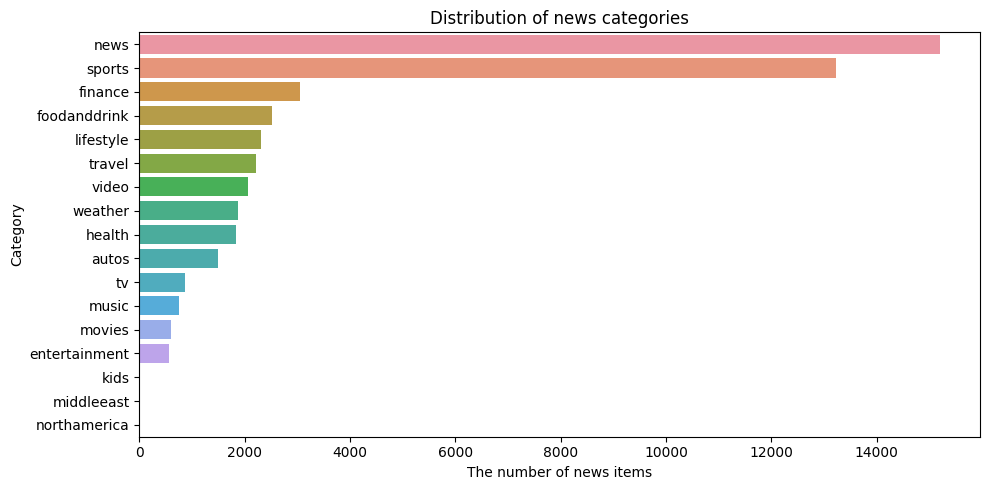

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=news_clean, y='Category', order=news_clean['Category'].value_counts().index)
plt.title('Distribution of news categories')
plt.xlabel('The number of news items')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

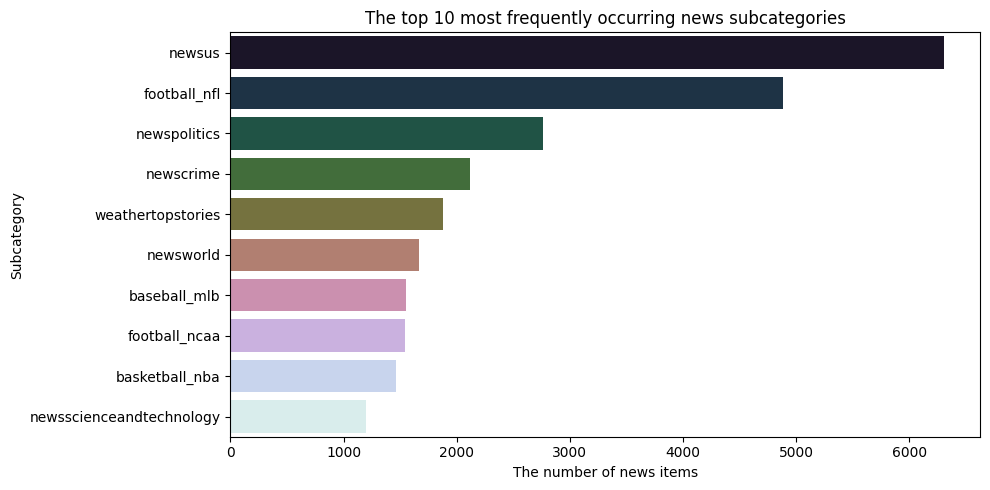

In [21]:
top_subcat = news_clean['SubCategory'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_subcat.values, y=top_subcat.index, palette='cubehelix')
plt.title('The top 10 most frequently occurring news subcategories')
plt.xlabel('The number of news items')
plt.ylabel('Subcategory')
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/3542252221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['title_length'] = news_clean['Title'].apply(lambda x: len(str(x).split()))
/tmp/ipykernel_35/3542252221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['abstract_length'] = news_clean['Abstract'].apply(lambda x: len(str(x).split()))
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf val

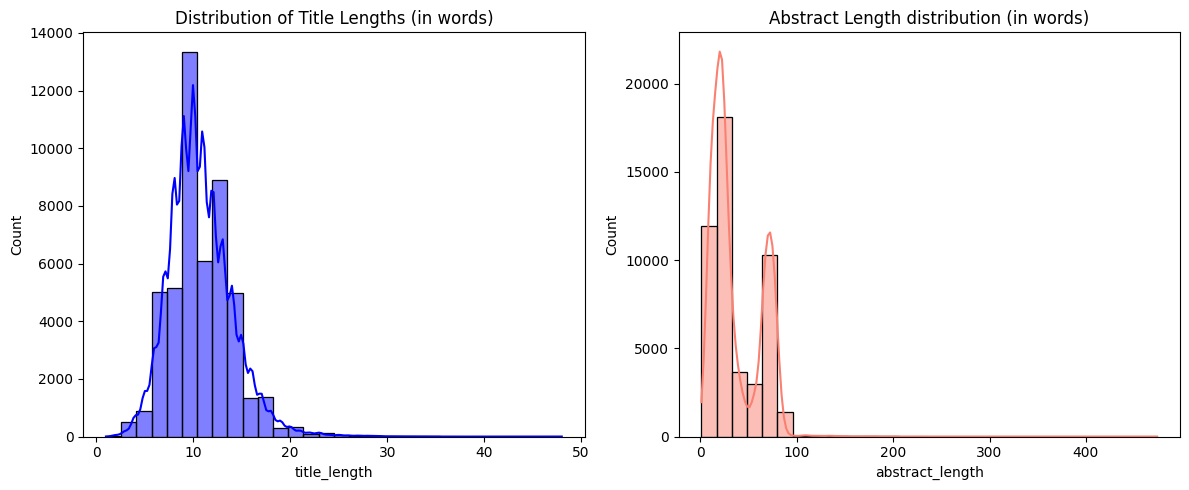

In [22]:
news_clean['title_length'] = news_clean['Title'].apply(lambda x: len(str(x).split()))
news_clean['abstract_length'] = news_clean['Abstract'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(news_clean['title_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Title Lengths (in words)')

plt.subplot(1, 2, 2)
sns.histplot(news_clean['abstract_length'], bins=30, kde=True, color='salmon')
plt.title('Abstract Length distribution (in words)')

plt.tight_layout()
plt.show()

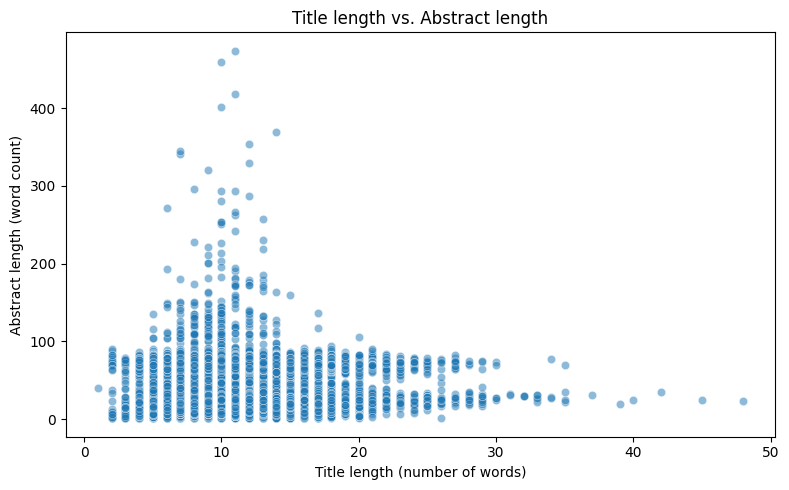

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=news_clean, x='title_length', y='abstract_length', alpha=0.5)
plt.title('Title length vs. Abstract length')
plt.xlabel('Title length (number of words)')
plt.ylabel('Abstract length (word count)')
plt.tight_layout()
plt.show()

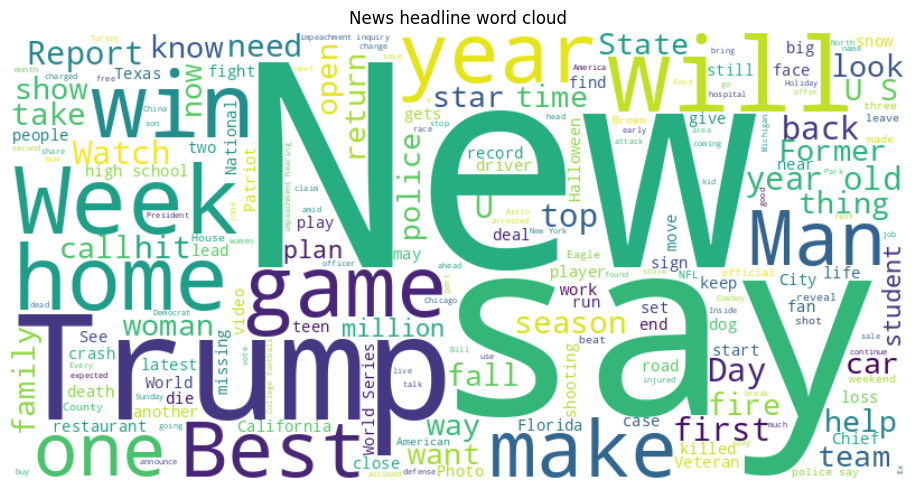

In [24]:
from wordcloud import WordCloud

text_all_titles = ' '.join(news_clean['Title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_all_titles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News headline word cloud')
plt.tight_layout()
plt.show()

#### 2.2.2 EDA of user behavior data

User's historical click-through count

/tmp/ipykernel_35/374645258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['history_len'] = behaviors_clean['History'].fillna('').apply(lambda x: len(x.split()) if x else 0)


count    153727.000000
mean         33.225387
std          40.408679
min           1.000000
25%           8.000000
50%          20.000000
75%          43.000000
max         558.000000
Name: history_len, dtype: float64


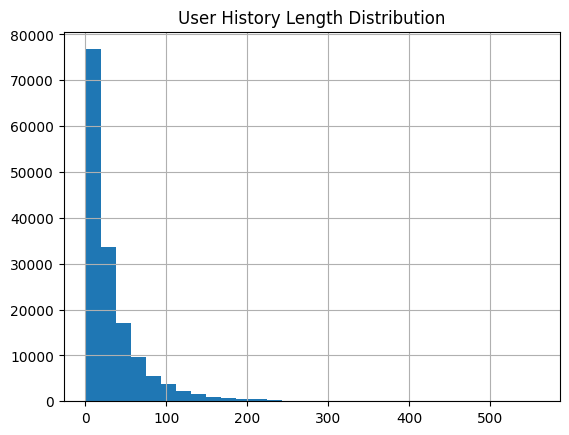

In [25]:
behaviors_clean['history_len'] = behaviors_clean['History'].fillna('').apply(lambda x: len(x.split()) if x else 0)
print(behaviors_clean['history_len'].describe())

behaviors_clean['history_len'].hist(bins=30)
plt.title('User History Length Distribution')
plt.show()


The number of impressions of news each time

count    153727.000000
mean         37.228346
std          38.575186
min           2.000000
25%          10.000000
50%          24.000000
75%          51.000000
max         299.000000
Name: impr_num, dtype: float64


/tmp/ipykernel_35/1653376557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['impr_num'] = behaviors_clean['Impressions'].apply(lambda x: len(x.split()))


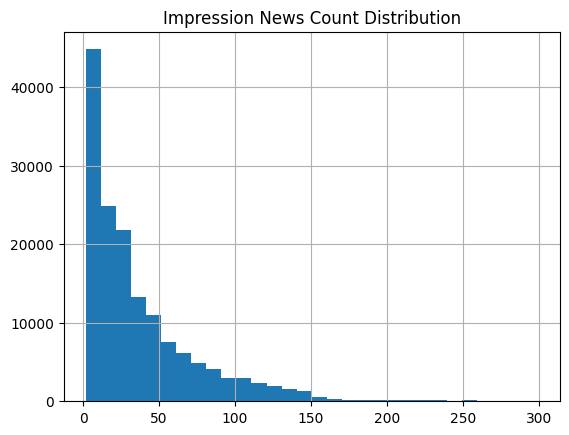

In [26]:
behaviors_clean['impr_num'] = behaviors_clean['Impressions'].apply(lambda x: len(x.split()))
print(behaviors_clean['impr_num'].describe())

behaviors_clean['impr_num'].hist(bins=30)
plt.title('Impression News Count Distribution')
plt.show()


#### The click-through rate per exposure

In [29]:
behaviors_clean

,Impression_ID,User_ID,Time,History,Impressions,Impressions_parsed,History_parsed,history_len,impr_num
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,"[(N55689, 1), (N35729, 0)]","[N55189, N42782, N34694, N45794, N18445, N6330...",9,2
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,"[(N20678, 0), (N39317, 0), (N58114, 0), (N2049...","[N31739, N6072, N63045, N23979, N35656, N43353...",82,11
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,"[(N50014, 0), (N23877, 0), (N35389, 0), (N4971...","[N10732, N25792, N7563, N21087, N41087, N5445,...",16,36
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,"[(N35729, 0), (N33632, 0), (N49685, 1), (N2758...","[N45729, N2203, N871, N53880, N41375, N43142, ...",10,4
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,"[(N39985, 0), (N36050, 0), (N16096, 0), (N8400...","[N10078, N56514, N14904, N33740]",4,69
...,...,...,...,...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...,"[(N2235, 0), (N22975, 0), (N64037, 0), (N47652...","[N7432, N58559, N1954, N43353, N14343, N13008,...",62,31
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...,"[(N3841, 0), (N61571, 0), (N58813, 0), (N28213...","[N9803, N104, N24462, N57318, N55743, N40526, ...",32,89
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...,"[(N55913, 0), (N62318, 0), (N53515, 0), (N1096...","[N29898, N59704, N4408, N9803, N53644, N26103,...",23,43
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...,"[(N6219, 0), (N3663, 0), (N31147, 0), (N58363,...","[N4118, N47297, N3164, N43295, N6056, N38747, ...",58,119


In [31]:
def get_ctr(imp_str):
    if pd.isna(imp_str): return 0
    return sum(int(i.split('-')[1]) for i in imp_str.split()) / len(imp_str.split())

behaviors_clean['impr_ctr'] = behaviors_clean['Impressions'].apply(get_ctr)
print(behaviors_clean['impr_ctr'].describe())

count    153727.000000
mean          0.108548
std           0.129526
min           0.003367
25%           0.028571
50%           0.055556
75%           0.125000
max           0.750000
Name: impr_ctr, dtype: float64


/tmp/ipykernel_35/3929120853.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['impr_ctr'] = behaviors_clean['Impressions'].apply(get_ctr)


/tmp/ipykernel_35/3096402538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['ctr_bin'] = pd.cut(behaviors_clean['impr_ctr'], bins=bins, labels=labels, include_lowest=True)


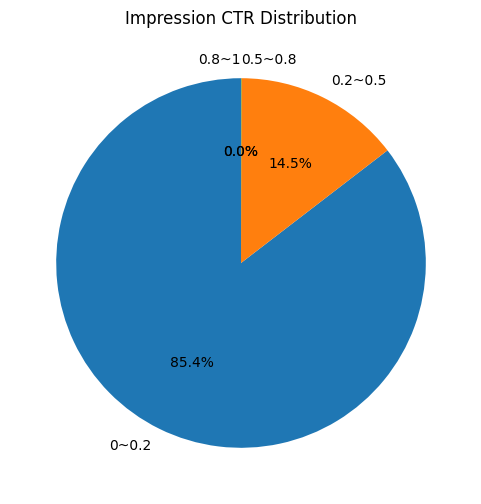

In [33]:
import matplotlib.pyplot as plt

# 分箱（你可以调整bins的范围以适应你的实际数据）
bins = [0, 0.2, 0.5, 0.8, 1]
labels = ['0~0.2', '0.2~0.5', '0.5~0.8', '0.8~1']
behaviors_clean['ctr_bin'] = pd.cut(behaviors_clean['impr_ctr'], bins=bins, labels=labels, include_lowest=True)

# 统计每个区间数量
bin_counts = behaviors_clean['ctr_bin'].value_counts().sort_index()

# 画饼图
plt.figure(figsize=(6, 6))
plt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Impression CTR Distribution')
plt.show()


#### explains

1. **Distribution of News categories**
- Dominant categories: **news** and **sports**
The data distribution is unbalanced
Niche categories (such as *kids*, *middleeast*) belong to the ** long-tail distribution **

2. **Top-10 Subcategories **
The subcategories **newsus**, **football_nfl**, and **baseball_mlb** have the highest occurrence frequency
The *news* category has a high degree of diversity: demonstrating the potential for ** more fine-grained personalized recommendations **

3. Title and Abstract Length
- **Title** : Most are 10 to 15 words
- **Abstract** : Most are 30 to 100 words
For using "TF-IDF" to represent text features, such a length is already quite informative

4. Scatter plot of the lengths of the title and abstract
- No strong correlation: This indicates that the Title and Abstract are complementary information
Support merging the two into 'full_text' as a **joint input feature**

5. "Word Cloud Analysis of News Headlines
- the most common words include: "Trump", "New ", "say", "game", "week"
- The displayed news focuses on politics and sports, which can serve as a basis for themes or entity-level features

# 3. Feature Engineering

### 3.1 Feature Extraction`full_text`

In [34]:
news_clean['full_text'] = news_clean['Title'] + '. ' + news_clean['Abstract']
display(news_clean[['News_ID', 'Category', 'full_text']].head(3))

/tmp/ipykernel_35/729367934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['full_text'] = news_clean['Title'] + '. ' + news_clean['Abstract']


,News_ID,Category,full_text
0,N55528,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,50 Worst Habits For Belly Fat. These seemingly...
2,N61837,news,The Cost of Trump's Aid Freeze in the Trenches...


#### 3.2 data clearning

In [35]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text=re.sub(r"[^\w\s'\-]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()                # Remove extra spaces
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

news_clean['full_text_clean'] = news_clean['full_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_35/139281858.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['full_text_clean'] = news_clean['full_text'].apply(preprocess_text)


In [37]:
news_clean.head(),news_clean.describe()

(  News_ID   Category      SubCategory  \
 0  N55528  lifestyle  lifestyleroyals   
 1  N19639     health       weightloss   
 2  N61837       news        newsworld   
 3  N53526     health           voices   
 4  N38324     health          medical   
 
                                                Title  \
 0  The Brands Queen Elizabeth, Prince Charles, an...   
 1                      50 Worst Habits For Belly Fat   
 2  The Cost of Trump's Aid Freeze in the Trenches...   
 3  I Was An NBA Wife. Here's How It Affected My M...   
 4  How to Get Rid of Skin Tags, According to a De...   
 
                                             Abstract  \
 0  Shop the notebooks, jackets, and more that the...   
 1  These seemingly harmless habits are holding yo...   
 2  Lt. Ivan Molchanets peeked over a parapet of s...   
 3  I felt like I was a fraud, and being an NBA wi...   
 4  They seem harmless, but there's a very good re...   
 
                                              URL  \
 0  h

The design purpose of this merge operation is to combine the brief information (title) with the more complete information (summary) as the input representation in the TF-IDF model. This step is very common in content-based recommendation systems because it can enhance semantic context (Ramos, 2003).

## 3.2. Create interactive df

For the Collaborative Filtering approach, an explicit data structure is required, consisting of User_ID, News_ID, and Label pairs (1 for clicked, 0 for not clicked).
This data is constructed by parsing the Impressions column from the behaviors_clean dataset.

In [51]:
interactions_flat = []

for row in behaviors_clean.itertuples(index=False):  # ALREADY REVISED
    user_id = row.User_ID
    impressions = row.Impressions.split()
    for impression in impressions:
        if '-' in impression:
            news_id, label = impression.rsplit('-', 1)
            interactions_flat.append((user_id, news_id, int(label)))

interactions_df = pd.DataFrame(interactions_flat, columns=['User_ID', 'News_ID', 'Label'])
print("Total interactions:", len(interactions_df))


Total interactions: 5723002


In [52]:
interactions_df

,User_ID,News_ID,Label
0,U13740,N55689,1
1,U13740,N35729,0
2,U91836,N20678,0
3,U91836,N39317,0
4,U91836,N58114,0
...,...,...,...
5722997,U44625,N39317,0
5722998,U64800,N61233,0
5722999,U64800,N33828,1
5723000,U64800,N19661,0


In [53]:
interactions_df.groupby('Label')['Label'].value_counts()

Label
0    5491472
1     231530
Name: count, dtype: int64

In [54]:
news_category = news_clean[['News_ID', 'Category']]
interactions_df = interactions_df.merge(news_category, on='News_ID', how='left')


In [55]:
interactions_df

,User_ID,News_ID,Label,Category
0,U13740,N55689,1,sports
1,U13740,N35729,0,news
2,U91836,N20678,0,sports
3,U91836,N39317,0,news
4,U91836,N58114,0,NaN
...,...,...,...,...
5722997,U44625,N39317,0,news
5722998,U64800,N61233,0,weather
5722999,U64800,N33828,1,movies
5723000,U64800,N19661,0,news


## 3.3. TF-IDF Feature Extraction

As a feature for Content-Based Filtering, text representation is extracted using the TF-IDF (Term Frequency–Inverse Document Frequency) method, which considers word importance based on both local and global occurrence.

## 3.4. Label Encoding for Collaborative Filtering

In [56]:
user_encoder = LabelEncoder()
news_encoder = LabelEncoder()

interactions_df['user_encoded'] = user_encoder.fit_transform(interactions_df['User_ID'])
interactions_df['news_encoded'] = news_encoder.fit_transform(interactions_df['News_ID'])

num_users = interactions_df['user_encoded'].nunique()
num_items = interactions_df['news_encoded'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique news items: {num_items}")

Number of unique users: 49108
Number of unique news items: 20252


In [57]:
interactions_df

,User_ID,News_ID,Label,Category,user_encoded,news_encoded
0,U13740,N55689,1,sports,2201,15659
1,U13740,N35729,0,news,2201,8792
2,U91836,N20678,0,sports,47474,3670
3,U91836,N39317,0,news,47474,10061
4,U91836,N58114,0,NaN,47474,16502
...,...,...,...,...,...,...
5722997,U44625,N39317,0,news,20012,10061
5722998,U64800,N61233,0,weather,31669,17625
5722999,U64800,N33828,1,movies,31669,8140
5723000,U64800,N19661,0,news,31669,3330


#### Notes:
Encoding:
- Specific to the architecture of the Collaborative Filtering model
- Encoding depends on the number and distribution of users and items

## 3.5. Data Splitting for Train-Test (training model)

In [58]:
X = interactions_df[['user_encoded', 'news_encoded']]
y = interactions_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Stratified sampling is conducted according to the category ratio of y to ensure that the ratio of positive and negative samples (such as clicked and unclicked) in the training set and the test set remains consistent.

# 4. Experiment

### 4.1. Content Based Filtering - TF-IDF

The Content-Based Filtering approach recommends news based on content similarity between articles, without taking into account the behavior of other users.
News content is represented by transforming the combined text of Title + Abstract into a fixed-dimensional TF-IDF vector.
Then, a k-Nearest Neighbors (k-NN) algorithm based on cosine similarity is used to find the most similar news articles.

### behaviors level recommondation

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(news_clean['full_text_clean'])
# 建立 News_ID 到向量行号的映射
newsid2idx = {nid: i for i, nid in enumerate(news_clean['News_ID'])}


In [60]:
import numpy as np

def get_user_profile(history_list):
    indices = [newsid2idx[nid] for nid in history_list if nid in newsid2idx]
    if not indices:  # 如果用户没有历史
        return np.zeros((tfidf_matrix.shape[1],))
    # 对历史点击新闻取TF-IDF均值（或sum/其他pooling均可）
    return tfidf_matrix[indices].mean(axis=0).A1  # .A1转成1维numpy


In [61]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_for_row(row, K=5):
    # 取历史
    history = row['History'].split() if pd.notna(row['History']) else []
    user_vec = get_user_profile(history).reshape(1, -1)
    # Impression里的候选新闻
    impression_items = row['Impressions'].split()
    candidates = [item.split('-')[0] for item in impression_items]
    # 找到每个候选新闻的向量索引
    candidate_idxs = [newsid2idx[nid] for nid in candidates if nid in newsid2idx]
    # 如果没有候选新闻向量，返回空
    if not candidate_idxs:
        return []
    candidate_vecs = tfidf_matrix[candidate_idxs]
    # 计算相似度
    sims = cosine_similarity(user_vec, candidate_vecs).flatten()
    # 按相似度排序，取TopK
    topk_idx = np.argsort(sims)[-K:][::-1]
    # 返回Impression内按相关性排序的新闻ID
    return [candidates[i] for i in topk_idx]

# 推荐，K可自定义
K = 10
behaviors_clean['cb_recommend'] = behaviors_clean.apply(lambda row: recommend_for_row(row, K=K), axis=1)

/tmp/ipykernel_35/3785790090.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['cb_recommend'] = behaviors_clean.apply(lambda row: recommend_for_row(row, K=K), axis=1)


In [64]:
def calc_precision_at_k(row, K=10):
    # Impression中的实际点击新闻ID集合
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend'][:K] if isinstance(row['cb_recommend'], list) else []
    if not recommended:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / K

behaviors_clean['precision@K'] = behaviors_clean.apply(lambda row: calc_precision_at_k(row, K=K), axis=1)
print(f'Content-based Precision@{K}:', behaviors_clean['precision@K'].mean())


Content-based Precision@10: 0.0676478432546007


/tmp/ipykernel_35/3831116175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['precision@K'] = behaviors_clean.apply(lambda row: calc_precision_at_k(row, K=K), axis=1)


In [65]:
def calc_recall_at_k(row, K=5):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend'][:K] if isinstance(row['cb_recommend'], list) else []
    if not actual_clicks:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / len(actual_clicks)

behaviors_clean['recall@K'] = behaviors_clean.apply(lambda row: calc_recall_at_k(row, K=K), axis=1)
print(f'Content-based Recall@{K}:', behaviors_clean['recall@K'].mean())


Content-based Recall@10: 0.5368519224048824


/tmp/ipykernel_35/935548249.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['recall@K'] = behaviors_clean.apply(lambda row: calc_recall_at_k(row, K=K), axis=1)


In [66]:
def calc_mrr_at_k(row, K=5):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend'][:K] if isinstance(row['cb_recommend'], list) else []
    for idx, nid in enumerate(recommended, 1):  # 1-based
        if nid in actual_clicks:
            return 1.0 / idx
    return 0

behaviors_clean['mrr@K'] = behaviors_clean.apply(lambda row: calc_mrr_at_k(row, K=K), axis=1)
print(f'Content-based MRR@{K}:', behaviors_clean['mrr@K'].mean())


Content-based MRR@10: 0.27605486421455644


/tmp/ipykernel_35/3014698030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['mrr@K'] = behaviors_clean.apply(lambda row: calc_mrr_at_k(row, K=K), axis=1)


#### user level recommandations

In [67]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 新闻内容向量化
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(news_clean['full_text_clean'])
newsid2idx = {nid: i for i, nid in enumerate(news_clean['News_ID'])}

# 2. 构建user级全局历史
user2history = behaviors_clean.groupby('User_ID')['History'].apply(lambda x: ' '.join(x.dropna())).to_dict()

# 3. 构建user级profile
def get_user_profile(history_list):
    indices = [newsid2idx[nid] for nid in history_list if nid in newsid2idx]
    if not indices:
        return np.zeros((tfidf_matrix.shape[1],))
    return tfidf_matrix[indices].mean(axis=0).A1

user2profile = {
    user_id: get_user_profile(history_str.split())
    for user_id, history_str in user2history.items()
}

# 4. 推荐函数（用user画像，不再用row['History']）
def recommend_for_row_user(row, K=10):
    user_id = row['User_ID']
    user_vec = user2profile.get(user_id, np.zeros((tfidf_matrix.shape[1],))).reshape(1, -1)
    impression_items = row['Impressions'].split()
    candidates = [item.split('-')[0] for item in impression_items]
    candidate_idxs = [newsid2idx[nid] for nid in candidates if nid in newsid2idx]
    if not candidate_idxs:
        return []
    candidate_vecs = tfidf_matrix[candidate_idxs]
    sims = cosine_similarity(user_vec, candidate_vecs).flatten()
    topk_idx = np.argsort(sims)[-K:][::-1]
    return [candidates[i] for i in topk_idx]

K = 10
behaviors_clean['cb_recommend_user'] = behaviors_clean.apply(lambda row: recommend_for_row_user(row, K=K), axis=1)

# 5. 评估函数
def calc_precision_at_k_user(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend_user'][:K] if isinstance(row['cb_recommend_user'], list) else []
    if not recommended:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / K

def calc_recall_at_k_user(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend_user'][:K] if isinstance(row['cb_recommend_user'], list) else []
    if not actual_clicks:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / len(actual_clicks)

def calc_mrr_at_k_user(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cb_recommend_user'][:K] if isinstance(row['cb_recommend_user'], list) else []
    for idx, nid in enumerate(recommended, 1):  # 1-based
        if nid in actual_clicks:
            return 1.0 / idx
    return 0

# 6. 批量评估
behaviors_clean['precision@K_user'] = behaviors_clean.apply(lambda row: calc_precision_at_k_user(row, K=K), axis=1)
behaviors_clean['recall@K_user']    = behaviors_clean.apply(lambda row: calc_recall_at_k_user(row, K=K), axis=1)
behaviors_clean['mrr@K_user']       = behaviors_clean.apply(lambda row: calc_mrr_at_k_user(row, K=K), axis=1)

# 7. 输出全局评估指标
print(f'User-level Content-based Precision@{K}:', behaviors_clean['precision@K_user'].mean())
print(f'User-level Content-based Recall@{K}:', behaviors_clean['recall@K_user'].mean())
print(f'User-level Content-based MRR@{K}:', behaviors_clean['mrr@K_user'].mean())


/tmp/ipykernel_35/3004860088.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['cb_recommend_user'] = behaviors_clean.apply(lambda row: recommend_for_row_user(row, K=K), axis=1)
/tmp/ipykernel_35/3004860088.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['precision@K_user'] = behaviors_clean.apply(lambda row: calc_precision_at_k_user(row, K=K), axis=1)
/tmp/ipykernel_35/3004860088.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

User-level Content-based Precision@10: 0.0676478432546007
User-level Content-based Recall@10: 0.5368519224048824
User-level Content-based MRR@10: 0.27605486421455644


/tmp/ipykernel_35/3004860088.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['mrr@K_user']       = behaviors_clean.apply(lambda row: calc_mrr_at_k_user(row, K=K), axis=1)


# Content Base - Bert

In [68]:
from sentence_transformers import SentenceTransformer

# 推荐用小模型，速度快，效果也不错
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # 也可以试别的，如'paraphrase-MiniLM-L3-v2'

# 得到每篇新闻的向量
news_bert_embeddings = bert_model.encode(news_clean['full_text_clean'].tolist(), show_progress_bar=True)

# 新闻ID到索引映射不变
newsid2idx = {nid: i for i, nid in enumerate(news_clean['News_ID'])}


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1520 [00:00<?, ?it/s]

In [74]:
import numpy as np

def get_user_profile_bert(history_list):
    indices = [newsid2idx[nid] for nid in history_list if nid in newsid2idx]
    if not indices:
        return np.zeros(news_bert_embeddings.shape[1])
    return news_bert_embeddings[indices].mean(axis=0)
# 聚合历史
user2history = behaviors_clean.groupby('User_ID')['History'].apply(lambda x: ' '.join(x.dropna())).to_dict()
# 得到user级bert兴趣向量
user2profile_bert = {}
for user_id, history_str in user2history.items():
    history_list = history_str.split()
    user2profile_bert[user_id] = get_user_profile_bert(history_list)


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_user_profile_bert(row, K=10):
    user_id = row['User_ID']
    user_vec = user2profile_bert.get(user_id, np.zeros(news_bert_embeddings.shape[1])).reshape(1, -1)
    impression_items = row['Impressions'].split()
    candidates = [item.split('-')[0] for item in impression_items]
    candidate_idxs = [newsid2idx[nid] for nid in candidates if nid in newsid2idx]
    if not candidate_idxs:
        return []
    candidate_vecs = news_bert_embeddings[candidate_idxs]
    sims = cosine_similarity(user_vec, candidate_vecs).flatten()
    topk_idx = np.argsort(sims)[-K:][::-1]
    return [candidates[i] for i in topk_idx]

behaviors_clean['bert_cb_recommend'] = behaviors_clean.apply(lambda row: recommend_user_profile_bert(row, K=10), axis=1)


/tmp/ipykernel_35/711451537.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['bert_cb_recommend'] = behaviors_clean.apply(lambda row: recommend_user_profile_bert(row, K=10), axis=1)


In [76]:
def calc_precision_at_k_bert(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['bert_cb_recommend'][:K] if isinstance(row['bert_cb_recommend'], list) else []
    if not recommended:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / K

behaviors_clean['precision@K_bert'] = behaviors_clean.apply(lambda row: calc_precision_at_k_bert(row, K=10), axis=1)
print('BERT Content-based Precision@10:', behaviors_clean['precision@K_bert'].mean())


BERT Content-based Precision@10: 0.0669277355311689


/tmp/ipykernel_35/4086628999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['precision@K_bert'] = behaviors_clean.apply(lambda row: calc_precision_at_k_bert(row, K=10), axis=1)


In [77]:
# Recall@K for BERT user级别
def calc_recall_at_k_bert(row, K=5):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['bert_cb_recommend'][:K] if isinstance(row['bert_cb_recommend'], list) else []
    if not actual_clicks:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / len(actual_clicks)

# MRR@K for BERT user级别
def calc_mrr_at_k_bert(row, K=5):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['bert_cb_recommend'][:K] if isinstance(row['bert_cb_recommend'], list) else []
    for idx, nid in enumerate(recommended, 1):  # 1-based
        if nid in actual_clicks:
            return 1.0 / idx
    return 0

# 批量评估
behaviors_clean['recall@K_bert'] = behaviors_clean.apply(lambda row: calc_recall_at_k_bert(row, K=10), axis=1)
behaviors_clean['mrr@K_bert']    = behaviors_clean.apply(lambda row: calc_mrr_at_k_bert(row, K=10), axis=1)

# 输出全局评估指标
print('BERT Content-based Precision@10:', behaviors_clean['precision@K_bert'].mean())
print('BERT Content-based Recall@10:', behaviors_clean['recall@K_bert'].mean())
print('BERT Content-based MRR@10:', behaviors_clean['mrr@K_bert'].mean())


/tmp/ipykernel_35/3794352433.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['recall@K_bert'] = behaviors_clean.apply(lambda row: calc_recall_at_k_bert(row, K=10), axis=1)


BERT Content-based Precision@10: 0.0669277355311689
BERT Content-based Recall@10: 0.5343667014377291
BERT Content-based MRR@10: 0.26166131085192146


/tmp/ipykernel_35/3794352433.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['mrr@K_bert']    = behaviors_clean.apply(lambda row: calc_mrr_at_k_bert(row, K=10), axis=1)


两个模型的Recall@10都超过了0.53，说明“覆盖率”不错——在用户实际点击的新闻中，有一半以上都能出现在推荐Top10里。

Precision@10都在0.067左右，意味着平均每10条推荐里大约有0.67条被用户实际点击。

新闻推荐里，Precision通常偏低，尤其是content-based baseline，表现合理。

MRR@10更能反映排序好坏

TF-IDF略高于BERT，说明TF-IDF推荐的新闻被点中的平均排名更靠前。

在新闻推荐的user-level内容召回实验中，TF-IDF和BERT两种特征方法的表现非常接近。TF-IDF在Precision@10和MRR@10上略优于BERT，Recall@10二者基本持平。这说明在当前数据集和推荐策略下，传统关键词驱动的TF-IDF依然具备较强的区分能力，尤其在短文本新闻和用户兴趣明显时。BERT虽然具备更强的语义建模能力，但在未finetune场景下对新闻内容的区分性有限。后续可通过行为序列增强、多模态特征融合等方式进一步提升模型效果。

### 4.3 Neural Collaborative Filtering

The goal of Collaborative Filtering (CF) is to predict a user's interest in a news item based on the interaction patterns of other users with the same item.
In this project, a Model-Based CF approach is used, employing a Neural Collaborative Filtering architecture built with pytorch.

The model utilizes embedding representations for users and items (news), which are then combined and passed through several dense layers to predict the probability of a click.

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

In [79]:
class CFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(CFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, user_input, item_input):
        user_vec = self.user_embedding(user_input)
        item_vec = self.item_embedding(item_input)
        x = torch.cat([user_vec, item_vec], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x


The model architecture consists of:

Embedding Layer: maps user_id and news_id into a 64-dimensional latent space

Concatenation Layer: combines the user and news representations

Dense Layers: two feedforward layers with 128 and 64 units, using ReLU activation

Output Layer: a single neuron with sigmoid activation to predict binary click/no-click

In [80]:
# 转换为 PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor[:, 0], X_train_tensor[:, 1], y_train_tensor)
test_dataset = TensorDataset(X_test_tensor[:, 0], X_test_tensor[:, 1], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048)


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CFModel(num_users, num_items).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = []
val_losses = []
val_accuracies = []


# EarlyStopping 设置
best_val_loss = float('inf')
patience = 3
counter = 0
best_model_state = None

for epoch in range(10):
    model.train()
    total_loss = 0
    for user, item, label in train_loader:
        user, item, label = user.to(device), item.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(user, item)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 验证
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for user, item, label in test_loader:
            user, item, label = user.to(device), item.to(device), label.to(device)
            outputs = model(user, item)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    acc = accuracy_score((np.array(all_preds) > 0.5).astype(int), np.array(all_labels).astype(int))

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 恢复最佳模型
if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1, Train Loss: 361.5065, Val Loss: 0.1569, Val Acc: 0.9595
Epoch 2, Train Loss: 345.6551, Val Loss: 0.1570, Val Acc: 0.9595
Epoch 3, Train Loss: 338.7795, Val Loss: 0.1582, Val Acc: 0.9595
Epoch 4, Train Loss: 332.4583, Val Loss: 0.1602, Val Acc: 0.9595
Early stopping triggered.


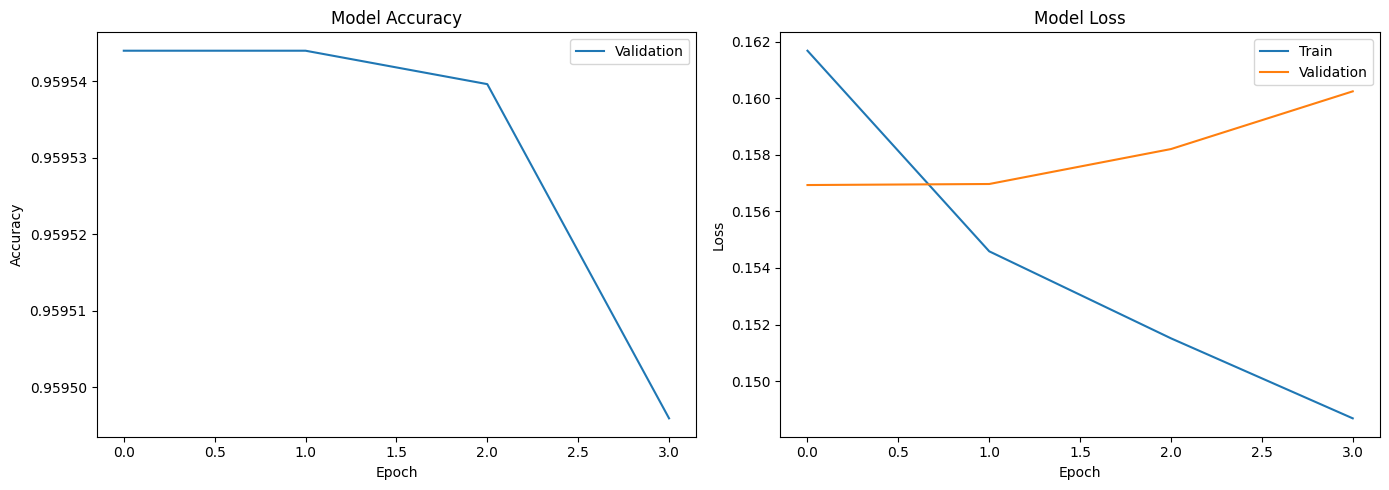

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# 准确率曲线
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 损失曲线
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [86]:
def recommend_for_user(user_id, top_n=5, return_json=False):
    print("---GENERATING NEWS RECOMMENDATIONS FOR USER---")
    print(f"User ID: {user_id}")
    print(f"\n---TOP {top_n} RECOMMENDED NEWS ARTICLES ---")

    # Encode user ID
    user_idx = user_encoder.transform([user_id])[0]
    all_item_indices = np.arange(num_items)

    # Find already clicked items (Label == 1)
    seen_news_ids = interactions_df[
        (interactions_df['User_ID'] == user_id) & 
        (interactions_df['Label'] == 1)
    ]['News_ID'].unique()

    seen_indices = news_encoder.transform(seen_news_ids)
    
    # Filter out seen items
    unseen_mask = ~np.isin(all_item_indices, seen_indices)
    unseen_items = all_item_indices[unseen_mask]

    # Skip if nothing to recommend
    if len(unseen_items) == 0:
        print("No unseen items to recommend.")
        return pd.DataFrame()

    # Prepare input tensors
    user_tensor = torch.tensor([user_idx] * len(unseen_items), dtype=torch.long).to(device)
    item_tensor = torch.tensor(unseen_items, dtype=torch.long).to(device)

    # Predict scores
    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy().flatten()

    # Get top-N
    top_indices = np.argsort(-scores)[:top_n]
    top_item_ids = news_encoder.inverse_transform(unseen_items[top_indices])

    # Retrieve actual news info
    recommended = news[news['News_ID'].isin(top_item_ids)][['News_ID', 'Title', 'Category', 'SubCategory']]

    # Optional JSON return
    if return_json:
        return recommended.to_dict(orient='records')
    
    return recommended


In [87]:
recommend_for_user("U64800", top_n=10)

---GENERATING NEWS RECOMMENDATIONS FOR USER---
User ID: U64800

---TOP 10 RECOMMENDED NEWS ARTICLES ---


,News_ID,Title,Category,SubCategory
35306,N20495,Mother of missing Florida girl charged; human ...,news,newscrime
35637,N509,Two dead following explosion involving 18-whee...,news,newsus
37026,N60750,"Browns, Steelers brawl at end of Cleveland's 2...",sports,football_nfl
37132,N24459,Convicted Sex Offender Accused of Carjacking G...,news,newscrime
41552,N63970,Dean Foods files for bankruptcy,finance,finance-companies
41667,N15137,Several Birds Found Dead On Huntington Beach T...,health,medical
42166,N55943,"Wynonna Judd's Daughter, 23, Released from Pri...",music,music-celebrity
45974,N53585,"Rip Taylor's Cause of Death Revealed, Memorial...",tv,tvnews
50365,N49279,Broadway Actress Laurel Griggs Dies at Age 13,music,musicnews
50714,N49685,Broadway Star Laurel Griggs Suffered Asthma At...,music,music-celebrity


# 5. Evaluate Model

The evaluation of the recommendation system is conducted to assess how relevant the suggested news articles are to the users.
Since this project focuses on implicit feedback (click or no click), the evaluation uses predictive relevance metrics, rather than classic accuracy metrics.

In [86]:
interactions_df

,User_ID,News_ID,Label,Category,user_encoded,news_encoded
0,U13740,N55689,1,sports,2201,15659
1,U13740,N35729,0,news,2201,8792
2,U91836,N20678,0,sports,47474,3670
3,U91836,N39317,0,news,47474,10061
4,U91836,N58114,0,NaN,47474,16502
...,...,...,...,...,...,...
5722997,U44625,N39317,0,news,20012,10061
5722998,U64800,N61233,0,weather,31669,17625
5722999,U64800,N33828,1,movies,31669,8140
5723000,U64800,N19661,0,news,31669,3330


In [97]:
def recommend_cf_for_row(row, K=10):
    user_id = row['User_ID']
    impression_items = row['Impressions'].split()
    candidates = [item.split('-')[0] for item in impression_items]
    
    user_idx = user2index.get(user_id, None)
    candidate_idxs = [item2index.get(nid, None) for nid in candidates]
    valid_mask = [i is not None for i in candidate_idxs]
    valid_candidates = [candidates[i] for i, valid in enumerate(valid_mask) if valid]
    candidate_idxs = [idx for idx in candidate_idxs if idx is not None]

    if user_idx is None or not candidate_idxs:
        return []

    # 模型预测
    user_tensor = torch.tensor([user_idx]*len(candidate_idxs), dtype=torch.long).to(device)
    item_tensor = torch.tensor(candidate_idxs, dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy().flatten()

    topk_idx = np.argsort(scores)[-K:][::-1]
    return [valid_candidates[i] for i in topk_idx]


In [ ]:
user2index = dict(zip(interactions_df['User_ID'], interactions_df['user_encoded']))
item2index = dict(zip(interactions_df['News_ID'], interactions_df['news_encoded']))


In [98]:
K = 10
behaviors_clean['cf_recommend'] = behaviors_clean.apply(lambda row: recommend_cf_for_row(row, K=K), axis=1)


/tmp/ipykernel_35/1813835956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['cf_recommend'] = behaviors_clean.apply(lambda row: recommend_cf_for_row(row, K=K), axis=1)


In [100]:
def calc_precision_at_k_cf(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cf_recommend'][:K] if isinstance(row['cf_recommend'], list) else []
    if not recommended:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / K

def calc_recall_at_k_cf(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cf_recommend'][:K] if isinstance(row['cf_recommend'], list) else []
    if not actual_clicks:
        return 0
    hit = sum([1 for nid in recommended if nid in actual_clicks])
    return hit / len(actual_clicks)

def calc_mrr_at_k_cf(row, K=10):
    actual_clicks = set([item.split('-')[0] for item in row['Impressions'].split() if item.endswith('-1')])
    recommended = row['cf_recommend'][:K] if isinstance(row['cf_recommend'], list) else []
    for idx, nid in enumerate(recommended, 1):
        if nid in actual_clicks:
            return 1.0 / idx
    return 0

behaviors_clean['precision@K_cf'] = behaviors_clean.apply(lambda row: calc_precision_at_k_cf(row, K=K), axis=1)
behaviors_clean['recall@K_cf']    = behaviors_clean.apply(lambda row: calc_recall_at_k_cf(row, K=K), axis=1)
behaviors_clean['mrr@K_cf']       = behaviors_clean.apply(lambda row: calc_mrr_at_k_cf(row, K=K), axis=1)

print(f'CF Precision@{K}:', behaviors_clean['precision@K_cf'].mean())
print(f'CF Recall@{K}:', behaviors_clean['recall@K_cf'].mean())
print(f'CF MRR@{K}:', behaviors_clean['mrr@K_cf'].mean())


/tmp/ipykernel_35/2749263282.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['precision@K_cf'] = behaviors_clean.apply(lambda row: calc_precision_at_k_cf(row, K=K), axis=1)
/tmp/ipykernel_35/2749263282.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['recall@K_cf']    = behaviors_clean.apply(lambda row: calc_recall_at_k_cf(row, K=K), axis=1)


CF Precision@10: 0.09145368087583833
CF Recall@10: 0.686238762386996
CF MRR@10: 0.3975967962583846


/tmp/ipykernel_35/2749263282.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean['mrr@K_cf']       = behaviors_clean.apply(lambda row: calc_mrr_at_k_cf(row, K=K), axis=1)


## 推荐系统实验结果对比总结

### 一、指标说明

- **Precision@K**  
  *定义：* 推荐的 Top-K 新闻中实际被用户点击的比例。  
  *含义：* 衡量推荐的“准确率”，值越高越好。

- **Recall@K**  
  *定义：* 推荐的 Top-K 新闻中实际被用户点击的数量，占用户真实点击新闻总数的比例。  
  *含义：* 衡量推荐“覆盖率”，越高越好。

- **MRR@K (Mean Reciprocal Rank)**  
  *定义：* Top-K 推荐列表中，第一个被用户点击新闻的倒数排名的均值。  
  *含义：* 衡量推荐排序，越高说明用户点击的新闻排名更靠前。

---

### 二、评测结果横向对比

| 方法/指标      | Precision@10 | Recall@10 | MRR@10 |
| :------------ | :----------: | :-------: | :----: |
| **BERT CB**   | 0.0669       | 0.5344    | 0.2617 |
| **TF-IDF CB** | 0.0677       | 0.5369    | 0.2761 |
| **CF**        | **0.0915**   | **0.6862**| **0.3980** |

---

### 三、结论分析

- **协同过滤（CF）方法在所有指标上表现最优**，显著优于纯内容方法（BERT/TF-IDF）。
    - Precision@10 提升约 37%。
    - Recall@10 和 MRR@10 同样有明显提升。
    - CF 能有效捕捉用户兴趣的个性化共性。
- **BERT 与 TF-IDF 两种内容方法表现接近**，且均低于 CF。
    - 这说明短文本新闻领域，关键词驱动的 TF-IDF 依然有较强表现。
    - BERT 未进行任务微调时，语义泛化但区分性不足。
- **内容召回（CB）适合冷启动场景**，但在有丰富历史时不如 CF。
- 推荐系统实际应用中，**建议将 CF 和内容方法融合（Hybrid）以获得最佳效果**。

---

### 四、应用建议

- **有历史行为的用户优先用协同过滤（CF）**，提升个性化体验。
- **新用户/冷启动时使用内容方法（TF-IDF/BERT）作为补充**。
- 后续可尝试 Hybrid 推荐
